In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skimage
import skimage.transform
import scipy
import time
import imageio # To write image, could also use opencv
import os
from PIL import Image

In [ ]:
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'

In [ ]:
dir = "/content/drive/MyDrive/OCR Project(SMU)/"

In [ ]:
FLAG='train'
if FLAG=='train':
    im_top = dir+'files/Images/'
    annotations_top = dir+'files/Annotations_Simple/'
    data_path = dir+'DATA/emnist-balanced-train.csv'
else:
    im_top = dir+'files/Images_Test/'
    annotations_top = dir+'files/Annotations_Simple_Test/'
    data_path = dir+'DATA/emnist-balanced-test.csv'

In [ ]:
# First column has label, using mappings to get associated class
df = pd.read_csv(data_path) # Literally never used pandas before
print(df.shape)
num_subj=df.shape[0] # Number of subjects to sample from

(112799, 785)


In [ ]:
im_size=(320,320) # Size of image to generate
num_gen=10000 # Number of images to generate
debug=False
shear_fn=lambda: np.random.random_integers(-5, 5)

0


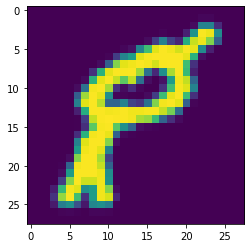

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 0 + 1) instead
  after removing the cwd from sys.path.


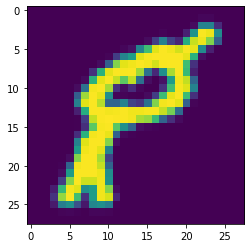

(51, 55)


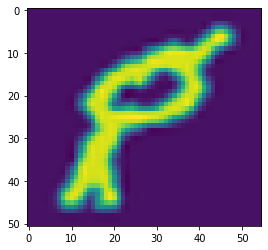

In [ ]:
num_gen=1

for i in range(num_gen):
    if (i%50)==0:
        print(i)
    t1=time.time()
    im=np.zeros((im_size[0],im_size[1],3)); # Initialize image
    check_mask=np.zeros((im_size[0],im_size[1])) # Initialize binary mask to keep track of where images have been placed
    annotation=[];    
    annotation2=[];
    # num_char=np.random.randint(low=20,high=50); # Randomly sample number of chars to place on image
    num_char=1;
    for j in range(num_char):
        idx=np.random.randint(low=0, high=num_subj);
        stream=df.iloc[idx,1:].to_numpy() # Return a Numpy representation of the DataFrame
        # print('Row'+str(j))
        # print(stream.shape)
        sample=np.reshape(stream,(28,28), order="F");
        # print(sample.shape)
        df.iloc[idx,0]
        # print("Label: "+str(label))
        plt.imshow(sample); plt.show()

        # Randomly sample shear augmentation
        tf = skimage.transform.AffineTransform(shear=np.deg2rad(shear_fn()))
        sample = skimage.transform.warp(sample, tf, order=1, preserve_range=True)
        plt.imshow(sample); plt.show()

        # Randomly sample scale of digit --> from 8% to 20% of full image size
        scale_y=(np.random.rand()*0.12)+0.08
        scale_x=(np.random.rand()*0.12)+0.08
        # sample=scipy.misc.imresize(sample,(int(scale_y*im_size[0]),int(scale_x*im_size[1])))
        sample = np.array(Image.fromarray(sample).resize((int(scale_y*im_size[0]),int(scale_x*im_size[1]))))
        print(sample.shape)
        plt.imshow(sample); plt.show()

        # Randomly sample placement onto full image
        place_x=np.random.randint(low=0,high=im_size[1]-sample.shape[1]-1)
        place_y=np.random.randint(low=0,high=im_size[0]-sample.shape[0]-1)

        # Only place image if we aren't overlapping any already existing images
        if np.sum(check_mask[place_y:place_y+sample.shape[0],place_x:place_x+sample.shape[1]])<1:
            im[place_y:place_y+sample.shape[0],place_x:place_x+sample.shape[1],0]=sample
            # im[place_y:place_y+sample.shape[0],place_x:place_x+sample.shape[1],1]=sample
            # im[place_y:place_y+sample.shape[0],place_x:place_x+sample.shape[1],2]=sample
            check_mask[place_y:place_y+sample.shape[0],place_x:place_x+sample.shape[1]]=1
            x1=place_x # Left border
            x2=place_x+sample.shape[1] # Right border
            y1=place_y # Top border
            y2=place_y+sample.shape[0] # Bottom border
            if debug:
                print('IMAGE PLACED')
            annotation2.append((str(label), str(x1/im_size[1]), str(x2/im_size[1]), str(y1/im_size[0]), str(y2/im_size[0])))
            annotation.append((label, x1, x2, y1, y2)) # Annotation to be passed to the xml generator
    
    im=im.astype(np.uint8)        
    # Get file IDs
    ct=len(os.listdir(im_top))
    ID = str(ct)
    while len(ID)<6:
        ID='0'+ID

    imageio.imwrite(im_top+ID+'.jpg',im) # Write image

    # Write simple version of annotations
    with open(annotations_top + ID + '.csv','w') as file:
        for j in range(len(annotation2)):
            for k in range(len(annotation2[j])):
                file.write(annotation2[j][k])
                file.write(',')
            file.write('\n')